In [8]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import optax

import hugegp as hg
import hugegp_cuda as hgc
import jaxkd as jk

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

key = jr.key(137)

In [ ]:
import jax
import jax.random as jr
import hugegp as hug

kp, kx = jr.split(jr.key(100))
points = jr.normal(kp, shape=(100_000, 2))
xi = jr.normal(kx, shape=(100_000,))

graph = hug.build_graph(points)
covariance = hug.matern_covariance(1e-3, 1e1, 1_000)
hug.generate(graph, covariance, xi)

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2591098721.py, line 4)

`graph` is just a tuple:
 - `points` is an array of input points in a topological order (which is also an interleaved k-d tree order)
 - `neighbors` is an array of *k* neighbor indices for each point, pointing to earlier positions in the topological order
 - `offsets` is a static tuple of level offsets, where each level can safely be generated in parallel

`covariance` is also a tuple:
 - `cov_bins` is a list of radii at which the covariance is evaluated, by default starting at `r=0.0` and then logarithmic bins from `r_min` to `r_max`
 - `cov_vals` is the covariance evaluated at that distance, typically with `1e-4` added to the first entry for stability

The `build_graph` operation does a few things, which we provide as separate functions for transparency:
 1. `build_tree` to sort the points into k-d binary tree order
 2. `alternating_tree_order` to reorder the indices at each level
 3. `query_cumulative_neighbors` to query the neighbors of each point amongst the preceding points
 4. `compute_levels` to trace the directed acyclic graph and find the level order and offsets

The tree order is probably a good heuristic guess for how to generate the points, but in principle it could be optimized further for a particular problem. Unfortunately, the `query_cumulative_neighbors` operation is very expensive in general and dramatically simplified if we choose the tree order. For users who want to experiment with other orders, there are helper functions in `hugegp.custom`. Note that `hugegp.generate` does not require tree order, just a topological order given the neighbor connectivity. We provide `hugegp.verify_graph` to check that this is satisfied, and `compute_levels` can be used to compute level offsets.

In [9]:
covariance = hg.test_cov_discretized(1e-3, 20, 1000)

# Test valid graph offsets

In [27]:
n_points = 100_000
start_level = 2
k = 4
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

In [28]:
tree = jk.build_tree(points)
points = points[tree.indices]
neighbors = hgc.query_previous_neighbors(points, tree.split_dims, k=k)

In [29]:
# Compute binary offsets
n_levels = len(points).bit_length() - 1
binary_offsets = (1 << jnp.arange(start_level, n_levels + 1, dtype=jnp.uint32)) - 1
binary_offsets = tuple(int(o) for o in binary_offsets)
binary_offsets += (n_points,)

In [30]:
# Compute interleaved offsets
interleaved_offsets = []
for i in range(len(binary_offsets) - 1):
    interleaved_offsets.append(binary_offsets[i])
    interleaved_offsets.append((binary_offsets[i + 1] - binary_offsets[i]) // 2 + binary_offsets[i])

interleaved_offsets = tuple(interleaved_offsets) + (n_points,)

In [31]:
# Compute valid offsets
graph = hg.graph.make_graph(points, n_initial=(1 << start_level) - 1, k=k)
valid_offsets = graph[1]

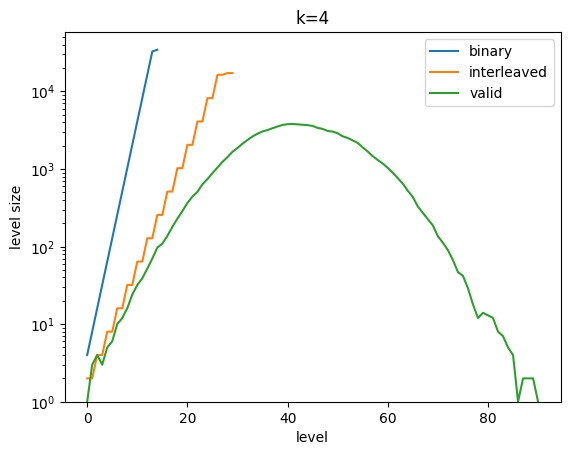

In [32]:
plt.plot(jnp.arange(len(binary_offsets)-1), np.diff(binary_offsets), label='binary')
plt.plot(jnp.arange(len(interleaved_offsets)-1), np.diff(interleaved_offsets), label='interleaved')
plt.plot(jnp.arange(len(valid_offsets)-1), np.diff(valid_offsets), label='valid')
plt.gca().set(xlabel='level', ylabel='level size', yscale='log', ylim=1, title=f'k={k}')
plt.legend()
plt.show()

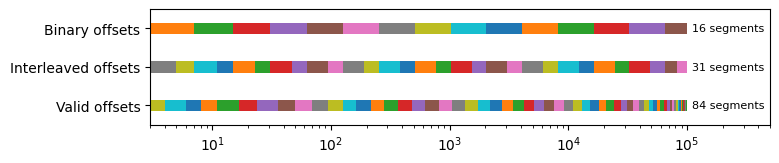

In [24]:
plt.figure(figsize=(8, 1.5))

for i in range(len(binary_offsets)):
    prev = binary_offsets[i - 1] if i > 0 else 0
    plt.barh(2, binary_offsets[i] - prev, .3, left=prev)
plt.text(1.1*n_points, 2, f'{len(binary_offsets)} segments', va='center', ha='left', fontsize=8)

for i in range(len(interleaved_offsets)):
    prev = interleaved_offsets[i - 1] if i > 0 else 0
    plt.barh(1, interleaved_offsets[i] - prev, .3, left=prev)
plt.text(1.1*n_points, 1, f'{len(interleaved_offsets)} segments', va='center', ha='left', fontsize=8)

for i in range(len(valid_offsets)):
    prev = valid_offsets[i - 1] if i > 0 else 0
    plt.barh(0, valid_offsets[i] - prev, .3, left=prev)
plt.text(1.1*n_points, 0, f'{len(valid_offsets)} segments', va='center', ha='left', fontsize=8)

plt.gca().set(xscale='log', ylim=(-0.5, 2.5), xlim=(valid_offsets[0], 5*n_points), yticks=[0, 1, 2], yticklabels=['Valid offsets', 'Interleaved offsets', 'Binary offsets'])
plt.show()

# Test variance for valid offset vs binary offset

In [25]:
n_points = 1_000
start_level = 5
n_initial = (1 << start_level) - 1
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))
tree = jk.build_tree(points)
points = points[tree.indices]

In [36]:
n_trials = 10_000
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_trials, n_points))

k_scan = [4, 8, 16]
binary_variances = []
# valid_variances = []

# Binary offsets
for k in tqdm(k_scan, desc='k'):
    neighbors = hgc.query_coarse_neighbors(points, tree.split_dims, k=k)
    offsets = hg.graph.make_binary_offsets(start_level, n_points)
    graph = (points, offsets, neighbors)
    values = jax.vmap(Partial(hg.generate_refine, graph, covariance))(xi)
    binary_variances.append(jnp.var(values, axis=0))

# Valid offsets
# for k in tqdm(k_scan, desc='k'):
#     graph = hg.graph.make_graph(points, n_initial=n_initial, k=k)
#     values = jax.vmap(Partial(hg.generate_refine, graph, covariance))(xi)
#     valid_variances.append(jnp.var(values, axis=0))

k: 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


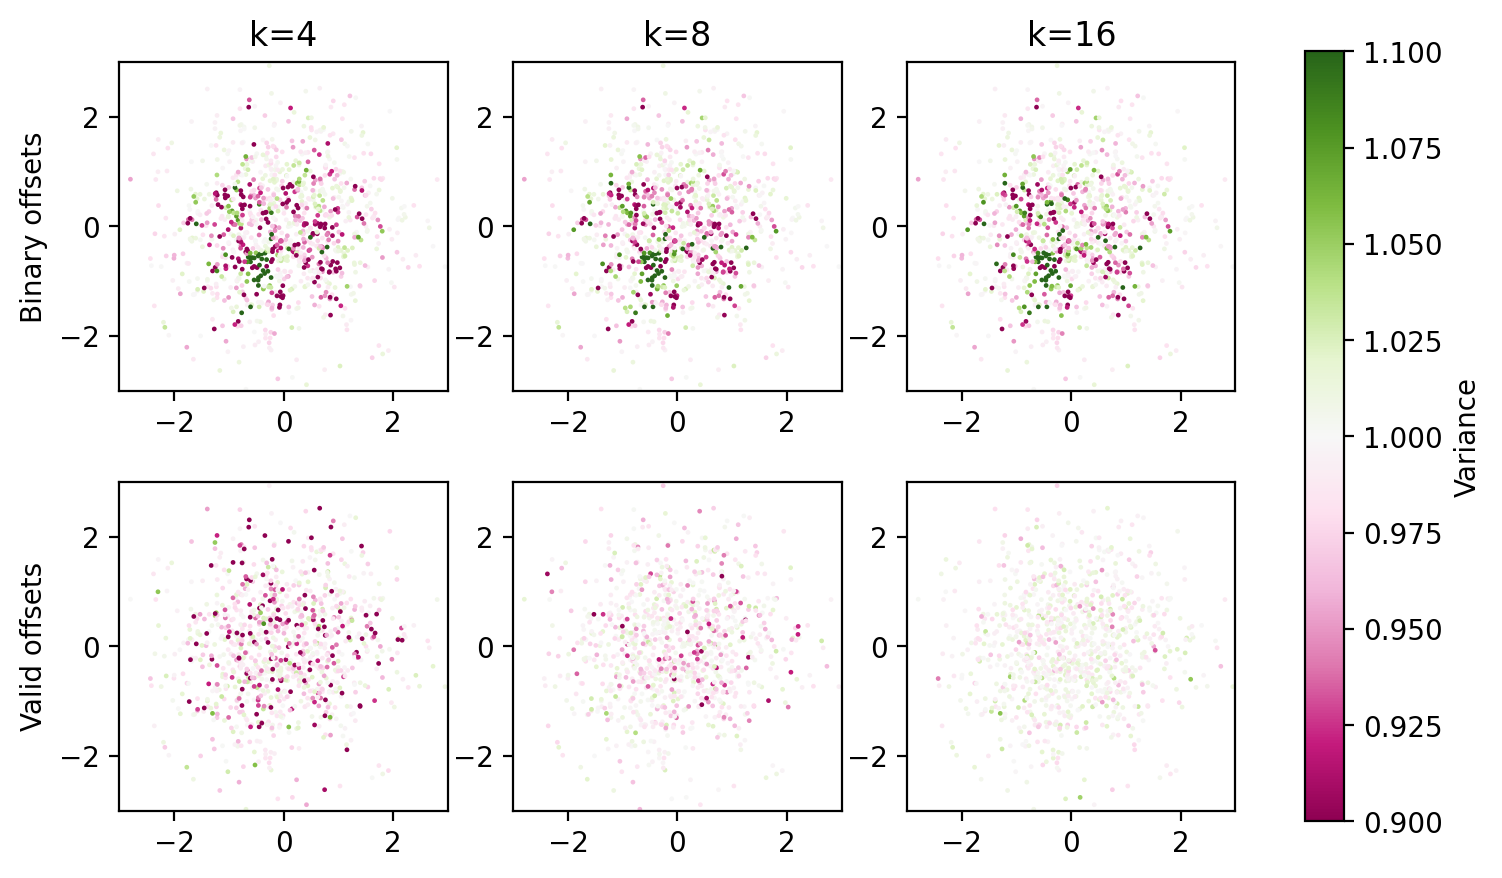

In [46]:
# Plot
fig, axes = plt.subplots(2, len(k_scan), figsize=(len(k_scan) * 3, 2 * 3 - 1), dpi=200)

for i, ax in enumerate(axes[0]):
    im = ax.scatter(*graph[0].T, c=binary_variances[i], s=0.5, vmin=0.9, vmax=1.1, cmap='PiYG')
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3), title=f'k={k_scan[i]}')
    if i == 0:
        ax.set_ylabel('Binary offsets')

for i, ax in enumerate(axes[1]):
    im = ax.scatter(*graph[0].T, c=valid_variances[i], s=0.5, vmin=0.9, vmax=1.1, cmap='PiYG')
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
    if i == 0:
        ax.set_ylabel('Valid offsets')

fig.colorbar(im, ax=axes, orientation='vertical', label='Variance')
plt.show()

# Test interleaved graph order

In [2]:
def make_offsets(base, n_initial, n_points):
    offsets = base ** jnp.arange(jnp.log2(n_initial)/jnp.log2(base), jnp.log2(n_points)/jnp.log2(base))
    return tuple(int(offset) for offset in offsets)

In [3]:
n_points = 1_000
n_initial = 100
k = 4
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))
covariance = hg.test_cov_discretized(1e-3, 20, 1000)

In [89]:
base_scan = [2, 1.5, 1.1, 1.05]
kl_scan = []

offsets = make_offsets(2, n_initial, n_points)
graph, _ = hg.build_custom_graph(points, offsets, k=k)
func = Partial(hg.generate, graph[0], covariance)
J_exact = jax.jacfwd(func)(jnp.zeros((n_points,)))
K_exact = J_exact @ J_exact.T

for base in tqdm(base_scan):
    offsets = make_offsets(base, n_initial, n_points)
    graph, _ = hg.build_custom_graph(points, offsets, k=k)

    func = Partial(hg.generate_refine, graph, covariance, cuda=False)
    J = jax.jacfwd(func)(jnp.zeros((n_points,)))
    K = J @ J.T

    solved = jnp.linalg.solve(K, K_exact)
    kl = 1 / 2 * (jnp.trace(solved) - jnp.linalg.slogdet(solved)[1] - len(K_exact))
    kl_per_dof = kl / n_points / jnp.log(2)

    kl_scan.append(kl_per_dof)

100%|██████████| 4/4 [00:54<00:00, 13.74s/it]


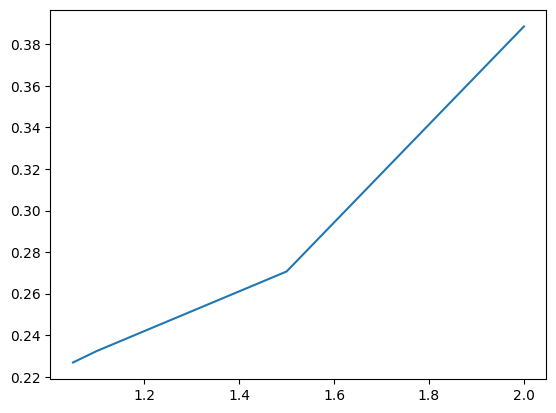

In [92]:
plt.plot(base_scan, kl_scan)
plt.show()

In [82]:
def generate(points, covariance, xi):
    L = jnp.linalg.cholesky(hg.covariance.cov_lookup_matrix(points, points, *covariance))
    values = L @ xi
    return values


def generate_refine(
    graph,
    covariance,
    xi,
    *,
    cuda=False,
):
    points, offsets, neighbors = graph
    cov_bins, cov_vals = covariance

    # Generate initial values
    initial_values = generate(points[: offsets[0]], covariance, xi[: offsets[0]])

    # Refine
    if cuda:
        hugegp_cuda.refine(
            points, offsets, neighbors, cov_bins, cov_vals, initial_values, xi
        )
    else:
        return refine(points, offsets, neighbors, cov_bins, cov_vals, initial_values, xi)


@Partial(jax.jit, static_argnums=(1,))
def refine(points, offsets, neighbors, cov_bins, cov_vals, initial_values, xi):
    values = [initial_values]
    offsets = offsets + (len(points),)

    for i in range(len(offsets) - 1):
        start = offsets[i]
        end = offsets[i + 1]

        fine_point = points[start:end][:, jnp.newaxis] # (n, 1, d)
        fine_xi = xi[start:end] # (n,)
        coarse_points = points[neighbors[start:end]] # (n, k, d)
        coarse_values = jnp.concatenate(values)[neighbors[start:end]] # (n, k)

        # Kff = hg.covariance.cov_lookup(0.0, cov_bins, cov_vals) # (,)
        # Kcc = hg.covariance.cov_lookup_matrix(coarse_points, coarse_points, cov_bins, cov_vals) # (n, k, k)
        # Kfc = hg.covariance.cov_lookup_matrix(fine_point, coarse_points, cov_bins, cov_vals) # (n, 1, k)
        # Kcf = jnp.swapaxes(Kfc, -2, -1) # (n, k, 1)

        Kff = hg.covariance.test_cov(0.0) # (,)
        Kcc = hg.covariance.test_cov_matrix(coarse_points, coarse_points) # (n, k, k)
        Kfc = hg.covariance.test_cov_matrix(fine_point, coarse_points) # (n, 1, k)
        Kcf = jnp.swapaxes(Kfc, -2, -1) # (n, k, 1)

        mean = Kfc @ jnp.linalg.solve(Kcc, coarse_values[:, :, jnp.newaxis]) # (n, 1, 1)
        mean = jnp.squeeze(mean, axis=(1,2)) # (n,)

        var = Kff - (Kfc @ jnp.linalg.solve(Kcc, Kcf)) # (n, 1, 1)
        var = jnp.squeeze(var, axis=(1,2)) # (n,)
        # var = jnp.maximum(var, 0.0)
        std = jnp.sqrt(var)
        values.append(mean + std * fine_xi)

    return jnp.concatenate(values)


In [4]:
n_points = 1_000
n_initial = 30
k = 4
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))
covariance = hg.test_cov_discretized(1e-3, 20, 1000)

In [273]:
n_trials = 10_000
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_trials, n_points))

bases = [2, 1.4, 1.05]
variances = []

for base in tqdm(bases):
    offsets = make_offsets(base, n_initial, n_points)
    graph, _ = hg.build_custom_graph(points, offsets, k=2)
    values = jax.vmap(Partial(generate_refine, graph, covariance, cuda=False))(xi)
    variance = jnp.var(values, axis=0)
    variances.append(variance)

# bases.append(0)
# values = jax.vmap(Partial(hg.generate, graph[0], covariance))(xi)
# variance = jnp.var(values, axis=0)
# variances.append(variance)

100%|██████████| 3/3 [00:38<00:00, 12.76s/it]


My conclusions from manual inspection:
 - variances of coarse values are close to 1
 - variance of fine value is 0.85
 - all matrices seem well behaved and not close to singular nor suspicious eigenvalues
 - variance of conditional mean is 0.55
 - conditional variance is 0.3

In [348]:
i = 251
fine_point = graph[0][i]
coarse_points = graph[0][graph[2][i]]
coarse_values = values[:, graph[2][i]]
coarse_variances = variances[1][graph[2][i]]
print(variances[0][i])

0.9087706


In [349]:
graph[2][i]

Array([123, 169], dtype=uint32)

In [322]:
graph[2][graph[2][i]]

Array([[ 27, 107],
       [105,  41]], dtype=uint32)

In [323]:
print(jnp.var(coarse_values, axis=0))
print(coarse_variances)

[1.0035902  0.99226654]
[1.0035902  0.99226665]


In [350]:
cov_bins, cov_vals = covariance
Kff = hg.covariance.cov_lookup(jnp.array([0.0]), cov_bins, cov_vals)
Kcc = hg.covariance.cov_lookup_matrix(coarse_points, coarse_points, cov_bins, cov_vals)
Kfc = hg.covariance.cov_lookup_matrix(fine_point, coarse_points, cov_bins, cov_vals).squeeze(-2)

In [351]:
jnp.cov(coarse_values, rowvar=False)

Array([[1.003683  , 0.26607555],
       [0.26607555, 0.99235696]], dtype=float32)

In [352]:
Kcc

Array([[1.0001    , 0.41563892],
       [0.41563892, 1.0001    ]], dtype=float32)

In [327]:
Kfc @ jnp.linalg.solve(Kcc, jnp.cov(coarse_values, rowvar=False))

Array([0.6215729, 0.5448281], dtype=float32)

In [311]:
Kfc @ jnp.linalg.solve(Kcc, coarse_variances[:, jnp.newaxis])

Array([0.92092085], dtype=float32)

In [312]:
jnp.var(Kfc @ jnp.linalg.solve(Kcc[jnp.newaxis], coarse_values[:, :, jnp.newaxis]))

Array(0.5415733, dtype=float32)

In [313]:
Kff - Kfc @ jnp.linalg.solve(Kcc, Kfc)

Array([0.3951981], dtype=float32)

In [314]:
jnp.linalg.solve(Kcc, Kfc[..., jnp.newaxis])

Array([[0.50999653],
       [0.41228163]], dtype=float32)

In [18]:
jnp.flatnonzero(variances[1] < 0.9)

Array([251, 267, 371, 379, 380, 425, 426, 436, 468, 503, 507, 513, 517,
       523, 540, 557, 577, 581, 584, 595, 603, 634, 641, 649, 650, 654,
       660, 684, 690, 697, 723, 726, 734, 737, 745, 758, 777, 778, 784,
       793, 808, 812, 830, 843, 844, 845, 846, 849, 873, 877, 883, 885,
       890, 897, 898, 901, 907, 936, 965, 968, 972, 979, 983, 995],      dtype=int32)

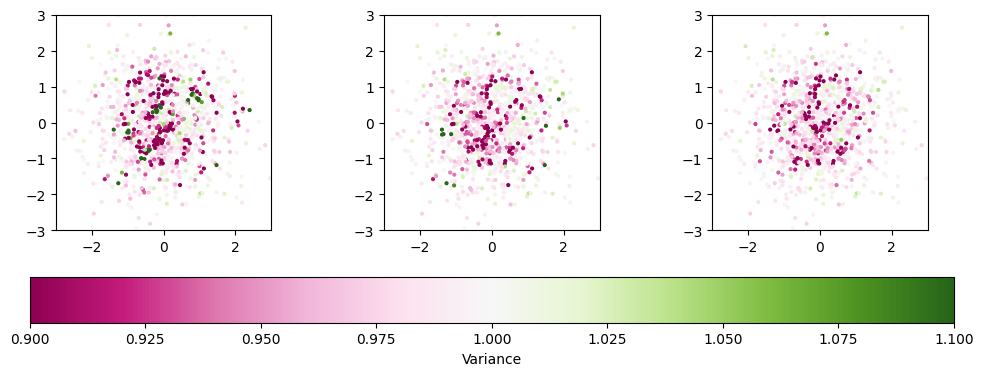

In [168]:
fig, axes = plt.subplots(1, len(bases), figsize=(len(bases) * 4, 4))

for i, ax in enumerate(axes):
    end = 1000
    ax.scatter(*graph[0][:end].T, c=variances[i][:end], s=4, vmin=0.9, vmax=1.1, cmap='PiYG')
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))

plt.colorbar(axes[0].collections[0], ax=axes, orientation='horizontal', label='Variance')
plt.show()

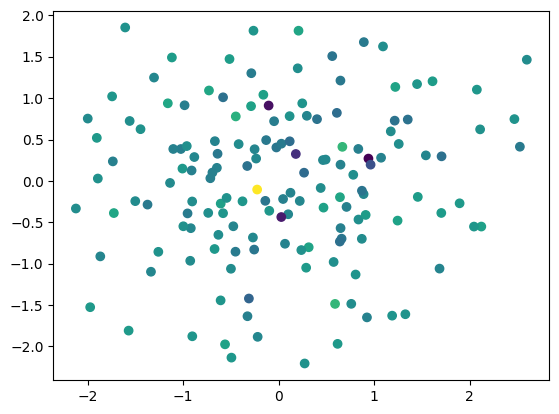

In [104]:
i = 4
plt.scatter(*graph[0][:graph[1][i]].T, c=variances[-2][:graph[1][i]], vmin=0.9, vmax=1.1)

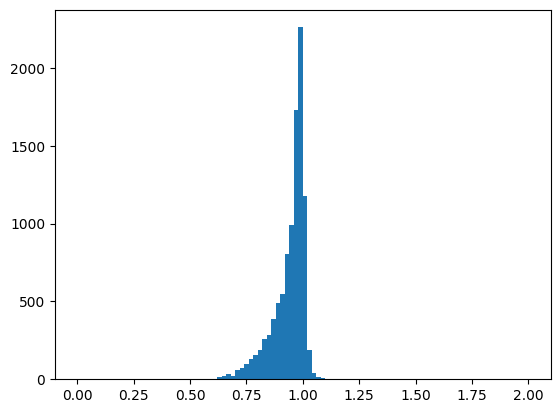

In [280]:
plt.hist(variances[2], range=(0, 2), bins=100)
plt.show()

In [ ]:
# Many trials


kd_values = jax.vmap(Partial(hg.generate_refine, kd_graph, covariance, cuda=False))(xi)
custom_values = jax.vmap(Partial(hg.generate_refine, custom_graph, covariance, cuda=False))(xi[:,custom_order])

kd_variance = jnp.var(kd_values, axis=0)
custom_variance = jnp.var(custom_values, axis=0)

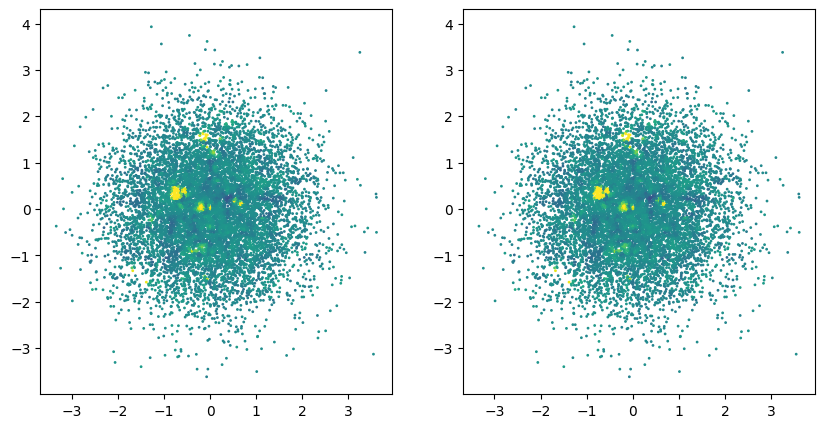

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(*kd_graph[0].T, c=kd_variance, s=1, cmap='viridis', vmin=0, vmax=2)
axes[1].scatter(*custom_graph[0].T, c=custom_variance, s=1, cmap='viridis', vmin=0, vmax=2)
plt.show()

In [ ]:
# Why aren't these identical?
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))

kd_values = hg.generate_refine(kd_graph, covariance, xi)
custom_values = hg.generate_refine(custom_graph, covariance, xi[custom_order])

plt.scatter(kd_values[custom_order], custom_values, s=1)

# Test JVP and VJP

In [13]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]

# Define the covariance
covariance = hg.test_cov_discretized(1e-3, 20, 1000)

In [44]:
# Random excitations
key, k1 = jr.split(key)
xi = jr.normal(k1, (2, n_points))

t1 = time.time()
values = hg.generate_refine(graph, covariance, xi[0], cuda=False).block_until_ready()
t2 = time.time()
values_cuda = hg.generate_refine(graph, covariance, xi[0], cuda=True).block_until_ready()
t3 = time.time()
print(f"Cuda time: {1000*(t3 - t2):.2f} ms")
print(f"Jax time: {1000*(t2 - t1):.2f} ms")

Cuda time: 22.02 ms
Jax time: 137.33 ms


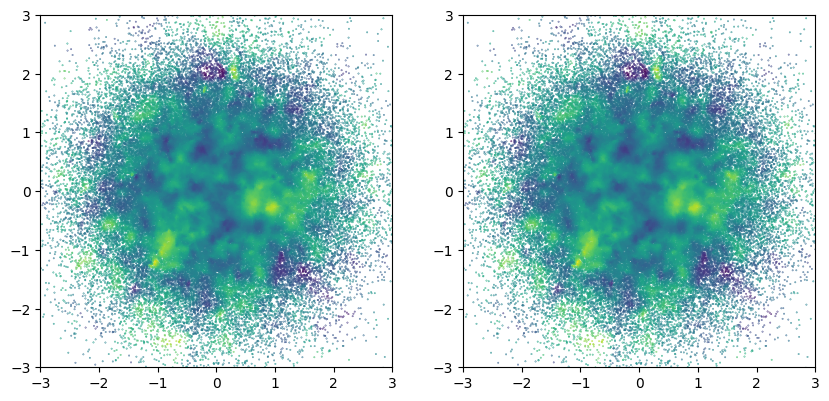

In [45]:
# Plot
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values, s=0.1, cmap='viridis')
axes[1].scatter(*points.T, c=values_cuda, s=0.1, cmap='viridis')
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
plt.show()

In [ ]:
plt.scatter()

In [7]:
func = Partial(hg.generate_refine, graph, covariance, cuda=False)
func_cuda = Partial(hg.generate_refine, graph, covariance, cuda=True)

func = jax.vmap(func)
func_cuda = jax.vmap(func_cuda)

In [8]:
_, dv = jax.jvp(func, (xi,), (jnp.ones_like(xi),))
dv[:,1023:]

Array([[1.8861809, 2.231175 , 2.2861686, ..., 4.0487843, 3.934006 ,
        2.9780335],
       [1.8861809, 2.231175 , 2.2861686, ..., 4.0487843, 3.934006 ,
        2.9780335]], dtype=float32)

In [9]:
_, dv_cuda = jax.jvp(func_cuda, (xi,), (jnp.ones_like(xi),))
dv_cuda[:,1023:]

Array([[1.886181 , 2.2311752, 2.2861686, ..., 4.048773 , 3.933982 ,
        2.978032 ],
       [1.886181 , 2.2311752, 2.2861686, ..., 4.048773 , 3.933982 ,
        2.978032 ]], dtype=float32)

In [10]:
primals_out, vjp_func = jax.vjp(func, xi)
vjp_eval = vjp_func(jnp.ones_like(xi))
vjp_eval[0][:,1023:]

Array([[3.22392235e+01, 4.45100479e+01, 3.30901108e+01, ...,
        1.43088065e-02, 2.52517425e-02, 1.59496907e-02],
       [3.22392235e+01, 4.45100479e+01, 3.30901108e+01, ...,
        1.43088065e-02, 2.52517425e-02, 1.59496907e-02]], dtype=float32)

In [11]:
primals_out, vjp_func = jax.vjp(func_cuda, xi)
vjp_eval_cuda = vjp_func(jnp.ones_like(xi))
vjp_eval_cuda[0][:,1023:]

ShapedArray(float32[2,1023])


Array([[3.22392273e+01, 4.45100479e+01, 3.30900879e+01, ...,
        1.43088065e-02, 2.52541024e-02, 1.59440842e-02],
       [3.22392235e+01, 4.45100441e+01, 3.30900841e+01, ...,
        1.43088065e-02, 2.52541024e-02, 1.59440842e-02]], dtype=float32)

In [ ]:
plt.plot(vjp_eval[0][1023:1200:], lw=1)
plt.plot(vjp_eval_cuda[0][1023:1200], lw=1, ls='--')
plt.gca().set(xlabel='random parameter', ylabel='vjp')
plt.show()

In [ ]:
plt.scatter(vjp_eval[0], vjp_eval_cuda[0], s=0.1)
plt.gca().set(aspect='equal', xscale='log', yscale='log', xlabel='jax vjp', ylabel='cuda vjp', title='order 2')
plt.show()

# Test Hessian

In [ ]:
key, k1, k2 = jr.split(key, 3)
n_points, graph, covariance = default_setup(k1)
xi = jr.normal(k2, (n_points,)) 

In [ ]:
def loss_func(xi, cuda=False):
    return jnp.sum(jnp.square(hg.generate_refine(graph, covariance, xi, cuda=cuda)))

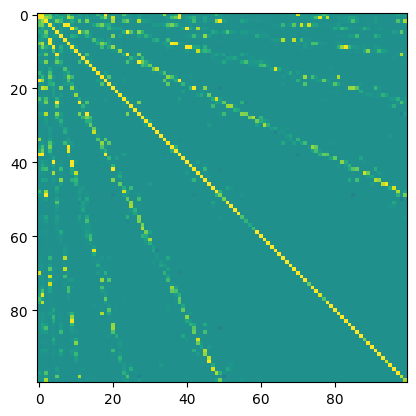

In [ ]:
plt.imshow(jax.hessian(Partial(loss_func, cuda=False))(xi), vmin=-1, vmax=1)

(100,) (7,)
(1, 100) (1, 7)
(1, 100) (1, 7)
(1, 100) (1, 7)
(100, 1, 100) (100, 1, 7)


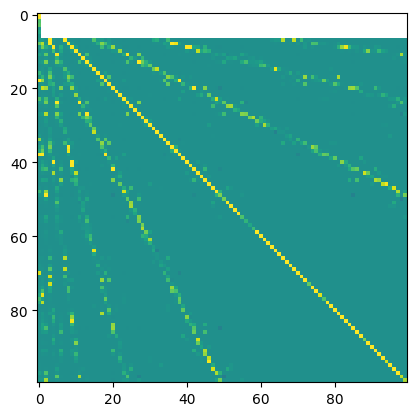

In [ ]:
plt.imshow(jax.hessian(Partial(loss_func, cuda=True))(xi), vmin=-1, vmax=1)

# Test gradient optimization


In [ ]:
# Generate points
n_points = 1_000_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]
n_initial = int(graph[1][0])

# Define the covariance
covariance = hg.covariance.test_cov_sampled()

# Generate truth
key, k1 = jr.split(key)
xi_true = jr.normal(k1, (n_points,))
values_true = hg.generate_refine(graph, covariance, xi_true, cuda=True).block_until_ready()
values_true

In [ ]:
# Set up optimization
optimizer = optax.adam(0.03)
key, k1 = jr.split(key)
xi_guess = jr.normal(k1, (n_points,))

def loss_fn(xi):
    values = hg.generate_refine(graph, covariance, xi, cuda=True)
    return jnp.sum(jnp.square(values - values_true))

# # Optimization step
@jax.jit
def step(carry):
    xi, optimizer_state = carry
    loss, grad = jax.value_and_grad(loss_fn)(xi)
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    xi = optax.apply_updates(xi, updates)
    return (xi, optimizer_state), loss

In [ ]:
# Optimize!
xi = xi_guess
optimizer_state = optimizer.init(xi_guess)
loss_hist = []
values_hist = []

for i in tqdm(range(1000)):
    (xi, optimizer_state), loss = step((xi, optimizer_state))
    loss_hist.append(float(loss))
    # values_hist.append(hg.generate_refine(graph, covariance, xi, cuda=True))

values = hg.generate_refine(graph, covariance, xi, cuda=True).block_until_ready()

plt.plot(loss_hist, lw=1)
plt.show()

In [ ]:
# Animate optimization
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values_true, s=1, cmap='viridis', vmin=-3, vmax=3)
s = axes[1].scatter(*points.T, c=values_hist[0], s=1, cmap='viridis', vmin=-3, vmax=3)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))

def update(i):
    s.set_array(values_hist[i])
    return s,

ani = FuncAnimation(fig, update, frames=jnp.arange(0, len(values_hist), 10), blit=True, interval=1000/10)
plt.close()
HTML(ani.to_html5_video())

In [ ]:
plt.scatter(values_true, values)

In [ ]:
plt.scatter(xi_true, xi, s=1)

# Test kernel derivatives

In [ ]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=5)
points = graph[0]
n_initial = int(graph[1][0])

# Generate some fixed xi
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))

# Define forward model
def forward(cov_params):
    cutoff, slope, scale = cov_params
    covariance = hg.covariance.test_cov_sampled(cutoff=cutoff, slope=slope, scale=scale)
    return hg.generate_refine(graph, covariance, xi, cuda=False)

# Generate true values
cov_params_true = jnp.array([0.2, -1.0, 1.0])
values_true = forward(cov_params_true)

In [ ]:
jax.jvp(forward, (cov_params_true,), (jnp.ones_like(cov_params_true),))

In [ ]:
jax.vjp(forward, cov_params_true)[1](jnp.ones_like(forward(cov_params_true)))

In [ ]:
cov_params_guess = jnp.array([0.8, -4.0, 0.3])
plt.scatter(*points.T, c=forward(cov_params_guess), s=1, cmap='viridis', vmin=-3, vmax=3)

In [ ]:
# Set up optimization
optimizer = optax.adam(0.03)
key, k1 = jr.split(key)
cov_params_guess = jnp.array([0.4, -3.0, 0.3])

def loss_fn(cov_params):
    values = forward(cov_params)
    return jnp.sum(jnp.square(values - values_true))

# # Optimization step
@jax.jit
def step(carry):
    cov_params, optimizer_state = carry
    loss, grad = jax.value_and_grad(loss_fn)(cov_params)
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    cov_params = optax.apply_updates(cov_params, updates)
    return (cov_params, optimizer_state), loss

In [ ]:
# Optimize!
cov_params = cov_params_guess
optimizer_state = optimizer.init(cov_params)
loss_hist = []
values_hist = []

for i in tqdm(range(100)):
    (cov_params, optimizer_state), loss = step((cov_params, optimizer_state))
    loss_hist.append(float(loss))
    values_hist.append(forward(cov_params))

values = forward(cov_params)

plt.plot(loss_hist, lw=1)
plt.show()

In [ ]:
# Animate optimization
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values_true, s=1, cmap='viridis', vmin=-3, vmax=3)
s = axes[1].scatter(*points.T, c=values_hist[0], s=1, cmap='viridis', vmin=-3, vmax=3)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))

def update(i):
    s.set_array(values_hist[i])
    return s,

ani = FuncAnimation(fig, update, frames=jnp.arange(0, len(values_hist), 10), blit=True, interval=1000/1)
plt.close()
HTML(ani.to_jshtml())

# Test manual AD of sqrt term

In [ ]:
fine_point = jnp.array([0.0, 0.0])
coarse_point = jnp.array([0.0, 1e-9])
r = jnp.linalg.norm(fine_point - coarse_point)


def cov_func(r, scale):
    result = scale * (1 + (r / 0.2) ** 2) ** (-1)
    result = jnp.where(r == 0.0, result * (1 + 1e-4), result)
    return result

def func(scale):
    Kff = cov_func(0.0, scale)
    Kfc = cov_func(r, scale)
    Kcc = cov_func(0.0, scale)
    return jnp.sqrt(Kff - Kfc**2 / Kcc)

def func_grad(scale):
    Kff = cov_func(0.0, scale)
    Kfc = cov_func(r, scale)
    Kcc = cov_func(0.0, scale)
    dKff = jax.grad(cov_func, argnums=1)(0.0, scale)
    dKfc = jax.grad(cov_func, argnums=1)(r, scale)
    dKcc = jax.grad(cov_func, argnums=1)(0.0, scale)
    return (dKff - 2*Kfc*dKfc/Kcc + Kfc**2/Kcc**2 * dKcc) / (2 * jnp.sqrt(Kff - Kfc**2 / Kcc))

print(func(1.0))
print(func_grad(1.0))
print(jax.grad(func)(1.0))

# Test per-pixel variance

In [85]:
# Generate points
n_points = 10_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=4)
points = graph[0]

# Define the covariance
covariance = hg.test_cov_discretized(1e-3, 20, 1000)

In [86]:
# Generate many random realizations
n_trials = 10_000
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_trials, n_points))
values = jax.vmap(Partial(hg.generate_refine, graph, covariance, cuda=True))(xi)
variance_per_point = jnp.var(values, axis=0)

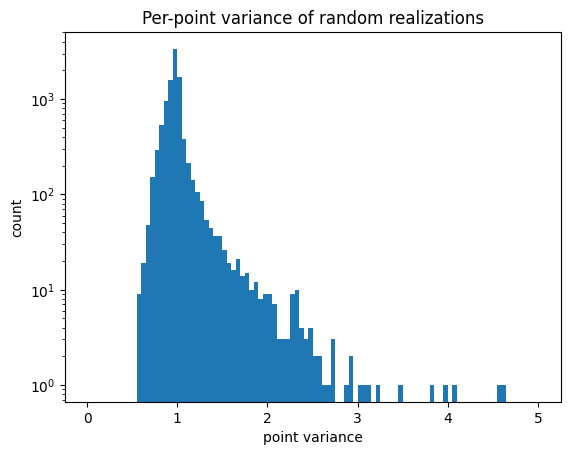

In [87]:
plt.hist(variance_per_point, bins=100, range=(0, 5))
plt.gca().set(yscale='log', xlabel='point variance', ylabel='count', title='Per-point variance of random realizations')
plt.show()

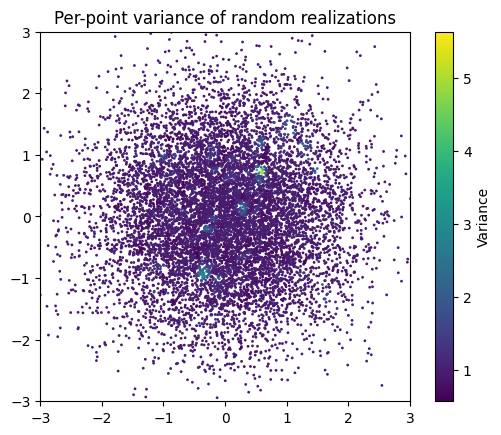

In [88]:
plt.scatter(*points.T, c=variance_per_point, s=1)
plt.gca().set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3), title='Per-point variance of random realizations')
plt.colorbar(label='Variance')
plt.show()

# Test KL as a function of neighbors

In [10]:
n_dim_scan = [1, 2, 3]
n_points_scan = [1000]
k_scan = [2, 3, 4, 5, 6, 7, 8]
kl_scan = []

covariance = hg.test_cov_discretized(1e-3, 10, 1000)

for n_dim in tqdm(n_dim_scan):
    kl_scan.append([])

    for n_points in n_points_scan:
        kl_scan[-1].append([])

        points_radius = jnp.logspace(-2, 0, n_points)
        key, k1 = jr.split(key)
        points = jr.normal(k1, (n_points, n_dim))
        points /= jnp.linalg.norm(points, axis=-1, keepdims=True)
        points *= points_radius[:, None]

        graph = hg.build_kd_graph(points, k=1, start_level=4)
        points = graph[0]
        exact_func = Partial(hg.generate, points, covariance)
        J_exact = jax.jacfwd(exact_func)(jnp.zeros((n_points,)))
        K_exact = J_exact @ J_exact.T
        
        for k in k_scan:
            graph = hg.build_kd_graph(points, k=k, start_level=4)
            func = Partial(hg.generate_refine, graph, covariance, cuda=True)
            J = jax.jacfwd(func)(jnp.zeros((n_points,)))
            K = J @ J.T

            solved = jnp.linalg.solve(K, K_exact)
            kl = 1 / 2 * (jnp.trace(solved) - jnp.linalg.slogdet(solved)[1] - len(K_exact))
            kl_per_dof = kl / n_points / jnp.log(2)

            kl_scan[-1][-1].append(kl_per_dof)

kl_scan = jnp.array(kl_scan)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


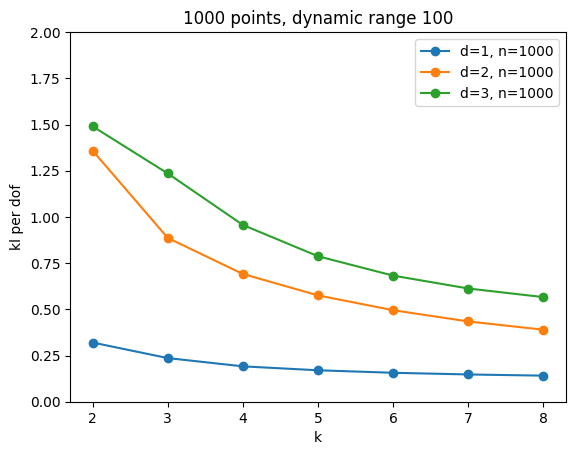

In [51]:
for n_dim in range(len(n_dim_scan)):
    plt.plot(k_scan, kl_scan[n_dim][0], marker='o', c=f'C{n_dim}', label=f'd={n_dim_scan[n_dim]}, n={n_points_scan[0]}')
    plt.legend()
plt.gca().set(ylim=(0,2), xlabel='k', ylabel='kl per dof', title=f'{n_points} points, dynamic range {points_radius[-1]/points_radius[0]:.0f}')
plt.show()

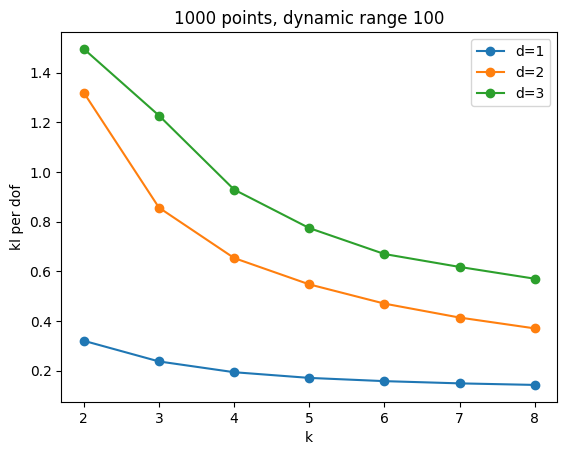

In [163]:
for n_dim in range(len(n_dim_scan)):
    plt.plot(k_scan, kl_scan[n_dim], label=f'd={n_dim_scan[n_dim]}', marker='o')
plt.legend()
plt.gca().set(xlabel='k', ylabel='kl per dof', title=f'{n_points} points, dynamic range {points_radius[-1]/points_radius[0]:.0f}')
plt.show()

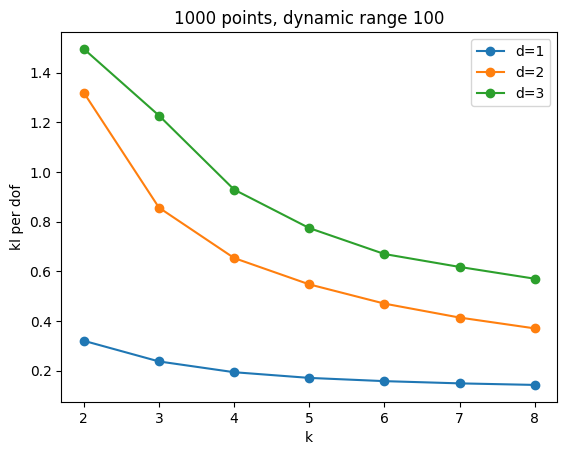

In [165]:
for n_dim in range(len(n_dim_scan)):
    plt.plot(k_scan, kl_scan[n_dim], label=f'd={n_dim_scan[n_dim]}', marker='o')
plt.legend()
plt.gca().set(xlabel='k', ylabel='kl per dof', title=f'{n_points} points, dynamic range {points_radius[-1]/points_radius[0]:.0f}')
plt.show()

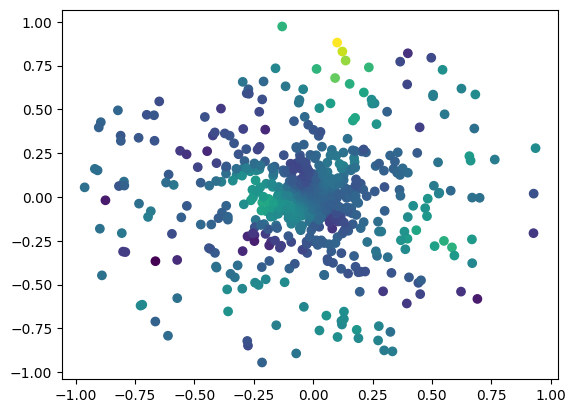

In [139]:
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))
values = func(xi)
plt.scatter(*points.T, c=values)
# plt.scatter(points, values)

# Test new topological order

In [91]:
def bit_reverse(n, bits):
    result = 0
    for i in range(bits):
        result = (result << 1) | (n & 1)
        n >>= 1
    return result

In [184]:
@jax.vmap
def bit_reverse_32(n, b):
    n = ((n >> 1) & 0x55555555) | ((n & 0x55555555) << 1)
    n = ((n >> 2) & 0x33333333) | ((n & 0x33333333) << 2)
    n = ((n >> 4) & 0x0F0F0F0F) | ((n & 0x0F0F0F0F) << 4)
    n = ((n >> 8) & 0x00FF00FF) | ((n & 0x00FF00FF) << 8)
    n = (n >> 16) | (n << 16)   
    n = n >> (32 - b)
    return n

In [195]:
indices = jnp.arange(25, dtype=jnp.uint32)
levels = jnp.asarray(jnp.frexp(indices + 1)[1] - 1, dtype=jnp.uint32)
level_indices = indices - ((1 << levels) - 1)
order = bit_reverse_32(level_indices, levels) + ((1 << levels) - 1)

In [196]:
order

Array([ 0,  1,  2,  3,  5,  4,  6,  7, 11,  9, 13,  8, 12, 10, 14, 15, 23,
       19, 27, 17, 25, 21, 29, 16, 24], dtype=uint32)

In [197]:
jnp.argsort(order)

Array([ 0,  1,  2,  3,  5,  4,  6,  7, 11,  9, 13,  8, 12, 10, 14, 15, 23,
       19, 17, 21, 16, 24, 20, 18, 22], dtype=int32)

In [ ]:
unsigned int bit_reverse32(unsigned int x) {
    x = ((x & 0xAAAAAAAA) >> 1)  | ((x & 0x55555555) << 1);
    x = ((x & 0xCCCCCCCC) >> 2)  | ((x & 0x33333333) << 2);
    x = ((x & 0xF0F0F0F0) >> 4)  | ((x & 0x0F0F0F0F) << 4);
    x = ((x & 0xFF00FF00) >> 8)  | ((x & 0x00FF00FF) << 8);
    x = (x >> 16) | (x << 16);
    return x;
}

In [96]:
bit_reverse(4, 4)

2